# Transfer Learning Using PyTorch Lightning ⚡️

## Setting up PyTorch Lightning

For this tutorial, we need PyTorch Lightning

In [2]:
!nvidia-smi

Sat May  6 13:25:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   56C    P0    62W / 150W |   3195MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Завершить все процессы, использующие ГПУ в нашей ОС
# !fuser -k /dev/nvidia[0]

In [4]:
import os

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torchvision.models as models
from PIL import Image
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms


## The Dataset 💿



In [5]:
class ClassificationDataset(Dataset):
    """
    Датасет с картинками, который производит изменения размера картинок,
    аугментации и преобразование в тензоры PyTorch
    """
    def __init__(self, img_paths, target, mode, rescale_size):
        super().__init__()
        # список файлов для загрузки
        self.files = img_paths
        
        # изменяем размер картинок датасета на указанный
        self.rescale_size = rescale_size
        
        # режим работы
        self.mode = mode
        self.available_modes = ['train', 'val', 'test']

        if self.mode not in self.available_modes:
            print(f"{self.mode} is not correct; correct modes: {self.available_modes}")
            raise NameError

        self.len_ = len(self.files)

        if self.mode != 'test':
            self.target = target
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(self.rescale_size),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])
        
            # transforms.Normalize делается для того, чтобы подогнать наши 
            # данные под данные на которых были предобучены наши нейронные сети
            # из torchvision.models они были обученные  на наборе данных 
            # ImageNet в документации по самому torchvision.models так же 
            # сказано https://pytorch.org/docs/stable/torchvision/models.html

            # All pre-trained models expect input images normalized in the same way,
            # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
            # where H and W are expected to be at least 224. The images have to be
            # loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406]
            # and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
            
            # И ниже код от самих разработчиков PyTorch
            # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])

        # трансформация с аугментацией для обучающей выборки средствами PyTorch
        transform_augment = transforms.Compose([
            transforms.Resize(size=self.rescale_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(hue=.1, saturation=.1),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        #x = np.array(x / 255, dtype='float32') *см. примечание ниже

        # У нас тр режима датасета 
        # DATA_MODES = ['train', 'val', 'test']
        # train - обучающая выборка на которой мы обучаем нейросеть 
        # (есть картинки и ответы к ним)
        # val - валидационная выборка на которой мы тестируем как хорошо
        #  нейросеть обучилась! (есть картинки и ответы к ним)
        # test - тестовая выборка на которой мы предсказываем ответы для
        #  скора в соревновании (есть картинки ответов нет!)

        if self.mode == 'test': # если тестовая выборка у нас нет ответов и
            x = transform(x)    # датасет не должен аугментировать картинки
            return x
        else:
            if self.mode == 'train': # аугментируем обучающую выборку
                x = transform_augment(x)
            else:
                x = transform(x) # не аугментируем валидационную выборку

            # для train или val выборок у нас есть ответы по классам
            y = self.target[index].item()

            return x, y

In [6]:
class ClassificationDataModule(pl.LightningDataModule):
    def __init__(self, df_train, df_val, df_test, img_path_col, target_col, rescale_size, batch_size, num_workers):
        super().__init__()

        # задаем параметры даталоадера
        self.rescale_size = rescale_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # задаем данные датасета
        train_paths = df_train[img_path_col].values
        train_target = df_train[target_col].values
        val_paths = df_val[img_path_col].values
        val_target = df_val[target_col].values
        test_paths = df_test[img_path_col].values
        test_target = df_test[target_col].values

        self.train = ClassificationDataset(train_paths,
                                           train_target,
                                           mode='train',
                                           rescale_size=self.rescale_size)

        self.val = ClassificationDataset(val_paths,
                                         val_target,
                                         mode='val',
                                         rescale_size=self.rescale_size)

        self.test = ClassificationDataset(test_paths,
                                          test_target,
                                          mode='test',
                                          rescale_size=self.rescale_size)

    def prepare_data(self):
        pass

    def train_dataloader(self):
        return DataLoader(self.train,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers)


## Загрузка данных

In [7]:
df_train = pd.read_csv('RAVDESS_frames_set/train.csv')
df_val = pd.read_csv('RAVDESS_frames_set/test.csv')

In [8]:
def df_change_paths(df, path, path_col):
    df[path_col] =  path + '/' + df[path_col]

In [9]:
# меняем пути у train и test
path2datset = 'RAVDESS_frames_set'
df_change_paths(df_train, path2datset, path_col = 'image_path')
df_change_paths(df_val, path2datset, path_col = 'image_path')

In [10]:
df_train.emotion_class -= 1
df_val.emotion_class -= 1

In [11]:
df_train

,image_path,emotion_class
0,RAVDESS_frames_set/train/02-01-01-01-01-01-02_...,0
1,RAVDESS_frames_set/train/02-01-01-01-01-01-02_...,0
2,RAVDESS_frames_set/train/02-01-01-01-01-01-02_...,0
3,RAVDESS_frames_set/train/02-01-01-01-01-01-02_...,0
4,RAVDESS_frames_set/train/02-01-01-01-01-01-02_...,0
...,...,...
12476,RAVDESS_frames_set/train/02-02-06-02-02-02-17_...,5
12477,RAVDESS_frames_set/train/02-02-06-02-02-02-17_...,5
12478,RAVDESS_frames_set/train/02-02-06-02-02-02-17_...,5
12479,RAVDESS_frames_set/train/02-02-06-02-02-02-17_...,5


In [12]:
df_val

,image_path,emotion_class
0,RAVDESS_frames_set/test/02-01-01-01-01-02-20_f...,0
1,RAVDESS_frames_set/test/02-01-01-01-01-02-20_f...,0
2,RAVDESS_frames_set/test/02-01-01-01-01-02-20_f...,0
3,RAVDESS_frames_set/test/02-01-01-01-01-02-20_f...,0
4,RAVDESS_frames_set/test/02-01-01-01-01-02-20_f...,0
...,...,...
3320,RAVDESS_frames_set/test/02-02-06-02-02-02-22_f...,5
3321,RAVDESS_frames_set/test/02-02-06-02-02-02-22_f...,5
3322,RAVDESS_frames_set/test/02-02-06-02-02-02-22_f...,5
3323,RAVDESS_frames_set/test/02-02-06-02-02-02-22_f...,5


In [13]:
# число различных эмоций в датасете
emotion_num = len(df_train.emotion_class.unique())
emotion_num

8

## LightingModule - Define the System

Let us look at the model definition to see how transfer learning can be used with PyTorch Lightning.
In the `LitModel` class, we can use the pre-trained model provided by Torchvision as a feature extractor for our classification model. Here we are using ResNet-18. A list of pre-trained models provided by PyTorch Lightning can be found here.
- When `pretrained=True`, we use the pre-trained weights; otherwise, the weights are initialized randomly.
- If `.eval()` is used, then the layers are frozen. 
- A single `Linear` layer is used as the output layer. We can have multiple layers stacked over the `feature_extractor`.

Setting the `transfer` argument to `True` will enable transfer learning.

In [14]:
# class LitModel(pl.LightningModule):
#     def __init__(self, input_shape, classes_num, learning_rate=1e-4, transfer=False):
#         super().__init__()

#         # log hyperparameters
#         self.save_hyperparameters()
#         self.learning_rate = learning_rate
#         self.dim = input_shape
#         self.step = 0

#         # transfer learning if pretrained=True
#         self.neural_net = models.resnet50(pretrained=transfer)
#         self.neural_net.fc = nn.Linear(2048, classes_num)

#         self.criterion = nn.functional.cross_entropy
#         # self.metric = f1

#     # will be used during inference
#     def forward(self, x):
#         return self.neural_net(x)

#     # def training_step(self, batch):
#     #     batch, gt = batch[0], batch[1]
#     #     out = self.forward(batch)
#     #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

#     #     # Write-Overwrites
#     #     # file1 = open("myfile.txt", "w")  # write mode
#     #     # file1.write(f"{out} \n")
#     #     # file1.write(f"{gt} \n")
#     #     # file1.close()

#     #     loss = self.criterion(out, gt)

#     #     # metric_value = self.metric(out, gt)

#     #     self.step += 1

#     #     self.log("train_loss", loss)
#     #     # self.log("train_f1", metric_value)
#     #     self.log("train_step", self.step)

#     #     return loss

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
        
#         loss = self.criterion(y_pred, y)
#         self.log("train_loss", loss)

#         return loss

#     # def validation_step(self, batch, batch_idx):
#     #     batch, gt = batch[0], batch[1]
#     #     out = self.forward(batch)
#     #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

#     #     # Write-Overwrites
#     #     # file1 = open("myfile.txt", "w")  # write mode
#     #     # file1.write(f"{out} \n")
#     #     # file1.write(f"{gt} \n")
#     #     # file1.close()

#     #     loss = self.criterion(out, gt)

#     #     self.log("val_loss", loss)

#     #     # metric_value = self.metric(out, gt)
#     #     # self.log("val_f1", metric_value)

#     #     return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
        
#         # Write-Overwrites
#         file1 = open("myfile.txt", "w")  # write mode
#         file1.write(f"{y_pred} \n")
#         file1.write(f"{y} \n")
#         file1.close()
        
#         loss = self.criterion(y_pred, y)
#         self.log("val_loss", loss)

#         return loss

#     # def predict_step(self, batch, batch_idx):
#     #     return self(batch).tolist()

#     # def test_step(self, batch, batch_idx):
#     #     batch, gt = batch[0], batch[1]
#     #     out = self.forward(batch)
#     #     out, gt = torch.argmax(out, dim=1).float(), torch.flatten(gt).float()

#     #     # Write-Overwrites
#     #     # file1 = open("myfile.txt", "w")  # write mode
#     #     # file1.write(f"{out} \n")
#     #     # file1.write(f"{gt} \n")
#     #     # file1.close()

#     #     loss = self.criterion(out, gt)

#     #     return loss  # {"loss": loss, "outputs": out, "gt": gt}

#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
        
#         # Write-Overwrites
#         file1 = open("myfile.txt", "w")  # write mode
#         file1.write(f"{y_pred} \n")
#         file1.write(f"{y} \n")
#         file1.close()
        
#         loss = self.criterion(y_pred, y)
#         self.log("test_loss : ", loss)

#         return loss

#     # def test_epoch_end(self, outputs):
#     #     loss = torch.stack([x['loss'].float() for x in outputs]).mean()
#     #     output = torch.cat([x['outputs'].float() for x in outputs], dim=0)

#     #     gts = torch.cat([x['gt'].float() for x in outputs], dim=0)

#     #     self.log("test_loss", loss)
#     #     # metric_value = self.metric(output, gts)
#     #     # self.log("test_f1", metric_value)

#     #     self.test_gts = gts
#     #     self.test_output = output

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [15]:
from torchmetrics.classification import F1Score

f1 = F1Score(task="multiclass", num_classes=emotion_num)


class LitModel(pl.LightningModule):
    def __init__(self, input_shape, classes_num, learning_rate=1e-4, fc_only=False):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.step = 0

        # transfer learning if pretrained=True
        self.neural_net = models.resnet50(pretrained=True)
        self.neural_net.fc = nn.Linear(2048, classes_num)

        if fc_only:
            self.set_trainable_fc_only()

        self.criterion = nn.functional.cross_entropy
        self.metric = f1

    def set_trainable_fc_only(self):
        # freeze params всей нейросети
        for param in self.neural_net.parameters():
            param.requires_grad = False

        # размораживаем веса для fc
        for param in self.neural_net.parameters():
            param.requires_grad = True

    # will be used during inference
    def forward(self, x):
        return self.neural_net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        loss = self.criterion(y_pred, y)

        # training metrics
        preds = torch.argmax(y_pred, dim=1)
        metric_value = self.metric(preds, y)

        self.step += 1

        self.log("train_loss", loss)
        self.log("train_f1", metric_value)
        self.log("train_step", self.step)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        loss = self.criterion(y_pred, y)

        # training metrics
        preds = torch.argmax(y_pred, dim=1)
        metric_value = self.metric(preds, y)

        self.log("val_loss", loss)
        self.log("val_f1", metric_value)

        return loss

    def predict_step(self, batch, batch_idx):
        
        x, y = batch
        pred = self.forward(x)
        preds = torch.argmax(pred, dim=1)
        return preds.tolist()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x)

        loss = self.criterion(y_pred, y)

        # training metrics
        preds = torch.argmax(y_pred, dim=1)

        return {"loss": loss, "outputs": preds, "gt": y}

    def test_epoch_end(self, outputs):
        loss = torch.stack([x['loss'].float() for x in outputs]).mean()
        output = torch.cat([x['outputs'].float() for x in outputs], dim=0)

        gts = torch.cat([x['gt'].float() for x in outputs], dim=0)

        self.log("test_loss", loss)
        mse = self.metric(output, gts)
        self.log("test_f1", mse)

        self.test_gts = gts
        self.test_output = output

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


## Train your Model 🏋️‍♂️

### Вначале определим оптимальный learning rate для нашей модели!

In [16]:
# создаем загрузчик данных
# dm = ClassificationDataModule(df_train=train_all,
#                           img_path_col='image_path',
#                           target_col='emotion_class',
#                           df_test=test,
#                           val_size=0.2,
#                           rescale_size=(224, 224),
#                           batch_size=64,
#                           num_workers=12)

In [17]:
dm = ClassificationDataModule(df_train,
                              df_val,
                              df_val,
                              img_path_col='image_path',
                              target_col='emotion_class',
                              rescale_size=(224, 224),
                              batch_size=64,
                              num_workers=12)

# Небольшая проверка работы загрузчика данных

In [18]:
data_loader = dm.train_dataloader()
image , label = next(iter(data_loader))

In [19]:
image.shape

torch.Size([64, 3, 224, 224])

In [20]:
label

tensor([3, 3, 1, 6, 3, 4, 3, 4, 2, 4, 7, 4, 2, 5, 1, 2, 3, 5, 3, 1, 4, 3, 2, 5,
        3, 2, 6, 4, 6, 1, 3, 5, 0, 2, 4, 5, 1, 5, 5, 2, 3, 6, 2, 2, 2, 6, 5, 1,
        3, 2, 3, 3, 1, 4, 7, 1, 3, 3, 1, 2, 2, 2, 1, 1])

# Обучение

In [21]:
model = LitModel((3, 224, 224), emotion_num, fc_only=False)
trainer = pl.Trainer(accelerator="gpu", log_every_n_steps=10)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
# запустим процесс подбора learning rate
lr_finder = trainer.tuner.lr_find(model, dm)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/admin-gpu/Downloads/datasets/emotion_rec/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('train_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/admin-gpu/Downloads/datasets/emotion_rec/.lr_find_6b571ed5-b7e4-4372-9a06-c391ab6ae779.ckpt
Restored all states from the checkpoint file at /home/admin-gpu/Downloads/datasets/emotion_rec/.lr_find_6b571ed5-b7e4-4372-9a06-c391ab6ae779.ckpt


In [23]:
# Results can be found in
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

0.0007585775750291836

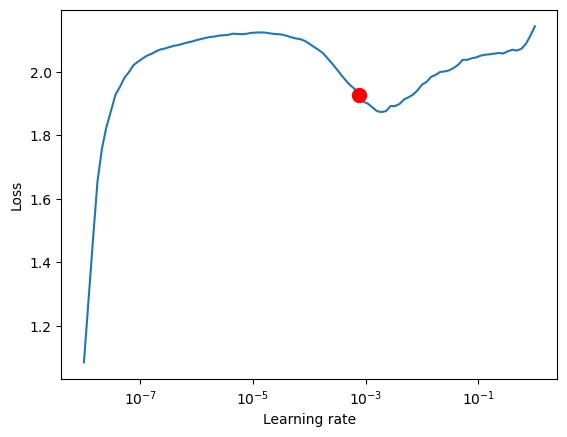

In [24]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

In [25]:
# зададим новый Lr модели
new_lr = 0.0004
new_lr

0.0004

### Непосредственно обучение модели

In [26]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# создадим обратный вызов на раннюю остановку обучения
early_stop_callback = EarlyStopping(monitor="val_f1", patience=10, verbose=False, mode="max")

# создадим обратный вызов на сохранение чекпоинта модели,
# по интересующей нас метрике
# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback_val_loss = ModelCheckpoint(
    save_top_k=5,
    monitor="val_loss",
    mode="min",
    filename="check_point-{epoch:02d}-{val_loss:.2f}",
)

# saves last-K checkpoints based on "global_step" metric
# make sure you log it inside your LightningModule
checkpoint_callback_last_step = ModelCheckpoint(
    save_top_k=1,
    monitor="train_step",
    mode="max",
    filename="check_point-{epoch:02d}-{train_step}",
)


### Обучение модели

In [27]:
# начинаем обучение модели

model = LitModel((3, 224, 224), emotion_num, fc_only=True, learning_rate=new_lr)

# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     max_epochs=10,
                     log_every_n_steps=10)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
# добавляем список обратных вызовов в параметр callbacks
trainer = pl.Trainer(accelerator="gpu", 
                     callbacks=[early_stop_callback,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_last_step],
                     log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model, dm)

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | neural_net | ResNet            | 23.5 M
1 | metric     | MulticlassF1Score | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.098    Total estimated model pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/admin-gpu/miniconda3/envs/detectron2/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [30]:
model = model.load_from_checkpoint("lightning_logs/version_1/checkpoints/check_point-epoch=01-val_loss=2.73.ckpt")

Протестируем полученную модель

In [31]:
# можем проверить на val части датасета
trainer.validate(model, dm)

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f1             0.4306766986846924
        val_loss            2.7344818115234375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.7344818115234375, 'val_f1': 0.4306766986846924}]

## Загрузим желаемый чекпоинт

In [32]:
# disable randomness, dropout, etc...
model.eval();

## Сделаем предсказание

### Сделаем предсказание на val

Проверим, что функции предсказания работаю корректно.
И что мы получаем тот же самый результат по метрике MSE, что и раньше.

In [63]:
# predict with the model
y_preds_batchs = trainer.predict(model, dm.val_dataloader())


You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 2it [00:00, ?it/s]

In [64]:
y_preds = []
for y_preds_batch in y_preds_batchs:
    y_preds.extend(y_preds_batch)

In [65]:
y_true = df_val['emotion_class'].values
y_true.size

3325

In [66]:
from sklearn.metrics import f1_score

# Оценим нашу модель на валидационной выборке:
print(f"F1 = {f1_score(y_true, y_preds, average='micro')}")

F1 = 0.4306766917293233


In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_preds, normalize='true')

In [86]:
cm = np.round((cm * 100), 2)

In [87]:
class_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

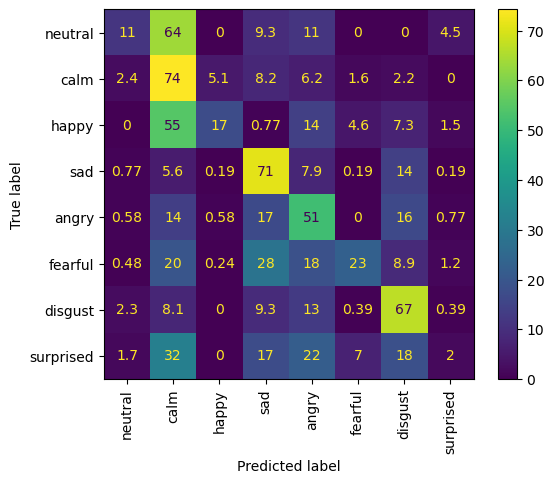

In [88]:
ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(xticks_rotation='vertical')

In [75]:
import sklearn

print(sklearn.__version__)

1.2.2


# Инференс модели

In [144]:
class EmotionNet:
    def __init__(self, model):
        self.neural_net = model.neural_net.eval()
        self.dim = model.dim
        
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        self.transform = transforms.Compose([
            transforms.Resize(model.dim[1:]),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

    def _load_image(self, path2image):
        image = Image.open(path2image)
        image.load()
        image = self.transform(image)
        # создаем батч из одной картинки
        image = image[None, :, :, :]
        return image
    
    def predict_on_image(self, path2image):
        image = self._load_image(path2image)
              
        with torch.no_grad():
            pred = self.neural_net(image)
            emotion_class = torch.argmax(pred, dim=1).tolist()[0]
            score = torch.softmax(pred, dim=1).flatten().tolist()[emotion_class]
        
        return emotion_class, score
        

In [145]:
emotion_net = EmotionNet(model)

In [146]:
path_to_image = 'RAVDESS_frames_set/test/02-02-03-02-01-02-24_frame_120_0.png'
emotion_cls, score = emotion_net.predict_on_image(path_to_image)

In [147]:
emotion_cls, score

(4, 0.7935910820960999)